In [1]:
# set cuda visible devices
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import os
if is_notebook():
    os.environ["CUDA_VISIBLE_DEVICES"] = "5" #"1"
    # os.environ['CUDA_LAUNCH_BLOCKING']="1"
    # os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [2]:
import torch 
torch.cuda.is_available()

True

# Hypothesis Testing Automatically Discovered Circuits

Procedure: 
- Compute prune scores (via attribution patching) 
- Search over different thresholds to find the smallest circuit where the null hypotheis of Equivalence / Dominance cannot be rejected 
- Prune edges from circuit that are not in paths to the output, or in the case of resample ablation cannot be reached from the input
- Test whether each edge in the circuit is minimal 
- Test whether the circuit is complete (by seeing if the null hypothesis on the independence test can be rejected)



In [3]:
import os
from typing import Callable, Dict, Tuple, Union, Optional, Any, Literal, NamedTuple
from itertools import product
from copy import deepcopy
import random
import math
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path

import torch
import numpy as np
from scipy.stats import binom, beta

import matplotlib.pyplot as plt
from tqdm import tqdm

from omegaconf import OmegaConf


from auto_circuit.utils.patchable_model import PatchableModel
from auto_circuit.types import BatchKey, PruneScores, CircuitOutputs, AblationType, Edge
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores
from auto_circuit.prune_algos.activation_patching import act_patch_prune_scores
from auto_circuit.visualize import draw_seq_graph
from auto_circuit.utils.custom_tqdm import tqdm
from auto_circuit.utils.tensor_ops import desc_prune_scores

from auto_circuit_tests.score_funcs import GradFunc, AnswerFunc
# from auto_circuit_tests.faithful_metrics import FaithfulMetric

from auto_circuit_tests.utils.auto_circuit_utils import run_circuit_with_edges_ablated

from auto_circuit_tests.hypo_tests.equiv_test import equiv_tests
from auto_circuit_tests.hypo_tests.minimality_test import (
    make_inflated_batch_prune_scores, 
    run_circuits_inflated_ablated, 
    minimality_test_edge,
    minimality_test, 
)
from auto_circuit_tests.hypo_tests.indep_test import independence_tests, indep_test
from auto_circuit_tests.hypo_tests.utils import (
    join_values, 
    remove_el,
    edges_from_mask, 
    result_to_json, 
)
from auto_circuit_tests.edge_graph import (
    SeqGraph,  
    sample_paths, 
    SampleType,
    edge_in_path
)

from auto_circuit_tests.tasks import TASK_DICT
from auto_circuit_tests.utils.utils import OUTPUT_DIR, RESULTS_DIR, repo_path_to_abs_path, load_cache, save_cache, save_json, load_json


/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [94]:
# config class
from dataclasses import dataclass, field
@dataclass 
class Config: 
    task: str = "Docstring Component Circuit" # check how many edges in component circuit (probably do all but ioi toen)
    ablation_type: AblationType = AblationType.RESAMPLE
    grad_func: GradFunc = GradFunc.LOGIT
    answer_func: AnswerFunc = AnswerFunc.MAX_DIFF
    ig_samples: Optional[int] = 10
    layerwise: bool = False
    act_patch: bool = True
    fracs: list[float] = field(default_factory=lambda:[1/2**n for n in range(1, 11)]) #TODO: switch to frac edges I guess
    prune_score_thresh: bool = False
    alpha: float = 0.05
    epsilon: Optional[float] = 0.1
    q_star: float = 0.9 
    sample_type: SampleType = SampleType.RANDOM_WALK
    # TODO: remove these?
    min_equiv_all_edges_thresh = 1000
    max_edges_to_test_in_order: int = 0 #TODO: change to 125
    max_edges_to_test_without_fail: int = 500 #TODO: change to 125
    save_cache: bool = True
    
    def __post_init__(self):
        # always override clean_corrupt for now
        self.clean_corrupt = "corrupt" if self.ablation_type == AblationType.RESAMPLE else None

In [95]:
# initialize config 
conf = Config()
#get config overrides if runnign from command line
if not is_notebook():
    import sys 
    conf_dict = OmegaConf.merge(OmegaConf.structured(conf), OmegaConf.from_cli(sys.argv[1:]))
    conf = Config(**conf_dict)

In [96]:
# handle directories
from auto_circuit_tests.utils.utils import get_exp_dir
task_dir, ablation_dir, out_answer_dir, ps_dir, edge_dir, exp_dir = get_exp_dir(
    task_key=conf.task, 
    ablation_type=conf.ablation_type,
    grad_func=conf.grad_func,
    answer_func=conf.answer_func,
    ig_samples=conf.ig_samples,
    layerwise=conf.layerwise,
    act_patch=conf.act_patch,
    alpha=conf.alpha,
    epsilon=conf.epsilon,
    q_star=conf.q_star,
    prune_score_thresh=conf.prune_score_thresh,
)
exp_dir.mkdir(parents=True, exist_ok=True)

In [97]:
# initialize task
task = TASK_DICT[conf.task]
task.init_task()

seq_len before divergence None
seq_len after divergence None


# Prune Scores

## Activation Patching Prune Scores

In [8]:
# load from cache if exists 
act_ps_path = out_answer_dir / "act_patch_prune_scores.pkl"
if act_ps_path.exists():
    act_prune_scores = torch.load(act_ps_path)
    act_prune_scores = {mod_name: -score for mod_name, score in act_prune_scores.items()} # negative b/c high score should imply large drop in performance
else:
    act_prune_scores = None

# if act_patch and act_patch doesn't exist, exit
if conf.act_patch and act_prune_scores is None:
    print("act_patch_prune_scores.pkl not found, exiting")
    exit()

/tmp/ipykernel_2676133/2672503182.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  act_prune_scores = torch.load(act_ps_path)


##  Attribution Patching Prune Scores

In [9]:
if not conf.act_patch:
    attr_ps_name = "attrib_patch_prune_scores"
    attr_ps_path = (ps_dir / attr_ps_name).with_suffix(".pkl")
    if (attr_ps_path).exists():
        attr_prune_scores = torch.load(attr_ps_path)
    else: 
        max_layer = max([edge.src.layer for edge in task.model.edges])

        attr_prune_scores = mask_gradient_prune_scores(
            model=task.model, 
            dataloader=task.train_loader,
            official_edges=None,
            grad_function=conf.grad_func.value, 
            answer_function=conf.answer_func.value, #answer_function,
            mask_val=0.0 if conf.ig_samples is None else None, 
            ablation_type=conf.ablation_type,
            integrated_grad_samples=conf.ig_samples, 
            # layers=max_layer if conf.layerwise else None,
            clean_corrupt=conf.clean_corrupt,
        )
        if conf.save_cache:
            torch.save(attr_prune_scores, attr_ps_path)

##  Compare Activation and Attribution Patching

In [10]:
from auto_circuit.types import PruneScores
import torch as t
def flat_prune_scores_ordered(prune_scores: PruneScores, order: list[str], per_inst: bool=False) -> t.Tensor:
    """
    Flatten the prune scores into a single, 1-dimensional tensor.

    Args:
        prune_scores: The prune scores to flatten.
        per_inst: Whether the prune scores are per instance.

    Returns:
        The flattened prune scores.
    """
    start_dim = 1 if per_inst else 0
    cat_dim = 1 if per_inst else 0
    return t.cat([prune_scores[mod_name].flatten(start_dim) for mod_name in order], cat_dim)

In [31]:
if not conf.act_patch:
    # order = sorted(list(act_prune_scores.keys()), key=lambda x: int(x.split('.')[1]))
    order = list(act_prune_scores.keys())
    act_prune_scores_flat = flat_prune_scores_ordered(act_prune_scores, order=order)
    attr_prune_scores_flat = flat_prune_scores_ordered(attr_prune_scores, order=order)

### MSE

In [ ]:
prune_score_diffs = [
    (act_prune_scores[mod_name] - attr_prune_scores[mod_name]).flatten()
    for mod_name, _patch_mask in task.model.patch_masks.items()
]
sq_error = torch.concat(prune_score_diffs).pow(2)
median_se = sq_error.median()
mean_se = sq_error.mean()
mse_result = {
    "median_se": median_se.item(),
    "mean_se": mean_se.item(),
}
print(mse_result)

In [ ]:
# mse and median se
if not conf.act_patch and act_prune_scores is not None:
    mse_result_name = "act_attr_mse"
    mse_result_path = (ps_dir / mse_result_name).with_suffix(".json")
    if mse_result_path.exists():
        mse_result = load_json(ps_dir, mse_result_name + '.json')
    else:
        prune_score_diffs = [
            (act_prune_scores[mod_name] - attr_prune_scores[mod_name]).flatten()
            for mod_name, _patch_mask in task.model.patch_masks.items()
        ]
        sq_error = torch.concat(prune_score_diffs).pow(2)
        median_se = sq_error.median()
        mean_se = sq_error.mean()
        mse_result = {
            "median_se": median_se.item(),
            "mean_se": mean_se.item(),
        }
        save_json(mse_result, ps_dir, mse_result_name)
    print(mse_result)

### Spearman Rank Correlation

In [ ]:

if not conf.act_patch and act_prune_scores is not None:
    from scipy import stats 
    abs_corr, abs_p_value = stats.spearmanr(act_prune_scores_flat.abs().cpu(), attr_prune_scores_flat.abs().cpu())
    corr, p_value = stats.spearmanr(act_prune_scores_flat.cpu(), attr_prune_scores_flat.cpu())
    print(f"abs corr: {abs_corr}, abs p-value: {abs_p_value}")
    print(f"corr: {corr}, p-value: {p_value}")

    spearman_results = {
        "abs_corr": abs_corr,
        "abs_p_value": abs_p_value,
        "corr": corr,
        "p_value": p_value,
    }
    # save_json(spearman_results, ps_dir, "spearman_results")

### Plot Rank 

In [34]:
def get_el_rank(x: t.Tensor) -> t.Tensor:
    indices = t.argsort(x)
    rank = torch.zeros_like(x)
    for i, index in enumerate(indices):
        rank[index] = i
    return rank

In [35]:
# get rank for scores
if not conf.act_patch:
    act_prune_scores_rank = get_el_rank(act_prune_scores_flat.cpu())
    attr_prune_scores_rank = get_el_rank(attr_prune_scores_flat.cpu())

In [ ]:
if not conf.act_patch:
    # TODO: plot x=0
    plt.scatter(act_prune_scores_rank, attr_prune_scores_rank, s=0.1)
    plt.xlabel("Act Patch Rank")
    plt.ylabel("Attrib Patch Rank")
    plt.title("Rank Correlation")

    # plt.savefig(ps_dir / "rank_corr.png")

In [ ]:
# TODO: I think there must be a bug? 
# get rank for scores
if not conf.act_patch:
    act_prune_scores_abs_rank = get_el_rank(act_prune_scores_flat.abs().cpu())
    attr_prune_scores_abs_rank = get_el_rank(attr_prune_scores_flat.abs().cpu())

    plt.scatter(act_prune_scores_abs_rank, attr_prune_scores_abs_rank, s=0.1)
    plt.xlabel("Act Patch Rank")
    plt.ylabel("Attrib Patch Rank")
    plt.title("Rank Correlation Abs")
    # plt.savefig(ps_dir / "rank_corr_abs.png")

### Compute Fraction of "Mis-Signed" Components

In [ ]:
if not conf.act_patch and act_prune_scores is not None:
    num_missigned = (act_prune_scores_flat.sign() != attr_prune_scores_flat.sign()).sum()
    frac_missigned = num_missigned / len(act_prune_scores_flat)
    print(f"Fraction of missigned: {frac_missigned}")
    # save_json({"frac_missigned": frac_missigned.item()}, ps_dir, "missigned")

### Compute Rank Distances  

In [ ]:
# TODO:

### Plot Scores

In [ ]:
if not conf.act_patch and act_prune_scores is not None:
    # plot scores on x, y
    plt.scatter(act_prune_scores_flat.cpu(), attr_prune_scores_flat.cpu(), alpha=0.25)
    plt.xlabel("Act Patch Scores")
    plt.ylabel("Attrib Patch Scores")
    plt.xscale("symlog")
    plt.yscale("symlog")
    # plt.savefig(ps_dir / "act_attr_scores.png")

In [ ]:
if not conf.act_patch and act_prune_scores is not None:
    # plot scores on x, y
    plt.scatter(act_prune_scores_flat.abs().cpu(), attr_prune_scores_flat.abs().cpu(), alpha=0.25)
    plt.xlabel("Act Patch Scores")
    plt.ylabel("Attrib Patch Scores")
    plt.xscale("log")
    plt.yscale("log")
    # plt.savefig(ps_dir / "act_attr_abs_scores.png")


In [ ]:
# # check if exp_dir is empty, and exit if so (temporary for running act patch comparisions without rerunning tests)
# if len(list(exp_dir.iterdir())) != 0:
#     print("exp_dir not empty, exiting")
#     exit()

# Construt Circuits from Prune Scores 

Constructing circuits from prune scores using either edge or fraction of prune score thresholds

In [10]:
# set prune scores
prune_scores = act_prune_scores if conf.act_patch else attr_prune_scores
# sort prune scores
sorted_prune_scores = desc_prune_scores(prune_scores)

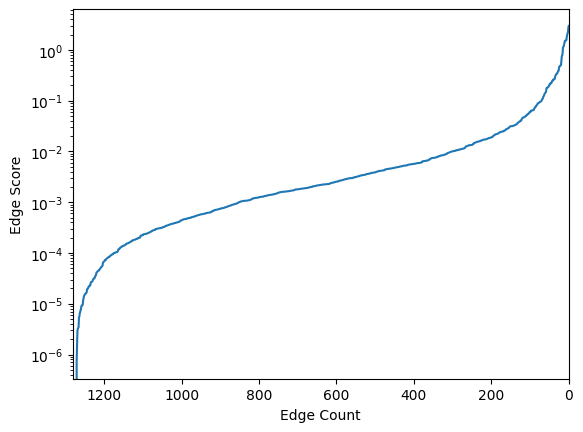

In [11]:
# plot prune scores
def plot_prune_scores(edge_scores):
    fig, ax = plt.subplots()
    # plot edge scores with x labels max to 0 
    ax.plot(sorted(edge_scores, reverse=True))
    ax.set_xlim(len(edge_scores), 0)
    # log axis 
    ax.set_yscale('log')
    ax.set_xlabel("Edge Count")
    ax.set_ylabel("Edge Score")
    return fig, ax

fig, ax = plot_prune_scores(sorted_prune_scores.cpu().numpy().tolist())
plt.savefig(exp_dir / "edge_scores.png")

In [12]:
# compute n_edges 
import math
circ_edges = []
if conf.prune_score_thresh: # frac total prune scores
    # get sum of prune scores up to each index 
    cum_prune_scores = np.cumsum(sorted_prune_scores.detach().cpu().numpy())
    # normalize by total prune scores
    norm_cum_prune_scores = cum_prune_scores / cum_prune_scores[-1] 
    for frac in conf.fracs:
        # get first index where fraction is greater than frac_prune_scores
        n_edges = np.argmax(norm_cum_prune_scores > (1 - frac)) 
        circ_edges.append(int(n_edges))
else: # frac edges
    circ_edges = [int(math.ceil(task.model.n_edges * frac)) for frac in reversed(conf.fracs)]
circ_thresholds = [sorted_prune_scores[n_edges].item() for n_edges in circ_edges]

save_json(circ_edges, edge_dir, "n_circ_edges")
save_json(circ_thresholds, edge_dir, "circ_thresholds")

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGIT_MAX_DIFF/act_patch/edges/n_circ_edges.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGIT_MAX_DIFF/act_patch/edges/circ_thresholds.json


# Faithfulness: % Loss Recovered and Equivalence Test

Use equivalence test from Shi et al to test a. if not equivalent and b. if equivalent

We also compute: 
- mean absolute error: E[abs(score(M) - score(C))] 
(spiritually similar to Transfomer Circuits not Robust and this comment https://www.lesswrong.com/posts/kcZZAsEjwrbczxN2i/causal-scrubbing-appendix#hJoCMcgXpk8jBLvb7, we don't do fraction of recovered b/c the negatives are weird and annoying)
- mean difference: E[score(M)] - E[score(C)] 
(kind of a middle ground, measuring bias)
- frac mean difference recovered: E[score(C)] - E[score(A)] / E[score(M)] - E[score(A)] 
(SAE work, similar to causal scrubbing, don't need to worry about variance)

In [13]:
# first full model outt and ablated model out
from auto_circuit_tests.utils.auto_circuit_utils import run_fully_ablated_model
from auto_circuit.types import BatchOutputs

model_out_train: BatchOutputs = {
    batch.key: task.model(batch.clean)[task.model.out_slice] 
    for batch in task.train_loader
}
model_out_test: BatchOutputs = {
    batch.key: task.model(batch.clean)[task.model.out_slice] 
    for batch in task.test_loader
}

ablated_out_train: BatchOutputs = run_fully_ablated_model(
    model=task.model,
    dataloader=task.train_loader,
    ablation_type=conf.ablation_type,
)

ablated_out_test: BatchOutputs = run_fully_ablated_model(
    model=task.model,
    dataloader=task.test_loader,
    ablation_type=conf.ablation_type,
)

Pruning Batch 1██████████| 2/2 [00:00<00:00, 12.36it/s]
Pruning Batch 1██████████| 2/2 [00:00<00:00, 11.82it/s]


In [14]:
# next get circuit outs for each threshold
from auto_circuit.prune import run_circuits
from auto_circuit.types import CircuitOutputs, PatchType
circuit_outs_train: CircuitOutputs = run_circuits(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.TREE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=False, 
)

circuit_outs_test: CircuitOutputs = run_circuits(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.TREE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=False, 
)

Pruning Batch 1██████████| 2/2 [00:01<00:00,  1.94it/s]
Pruning Batch 1██████████| 2/2 [00:01<00:00,  1.88it/s]


## Faithfulness Metrics

- mae: E[abs(score(M) - score(C))] 
- mean difference: E[score(M)] - E[score(C)] 
- frac mean difference recovered: E[score(C)] - E[score(A)] / E[score(M)] - E[score(A)]

In [15]:
# TODO: compute on train and test distribution
from auto_circuit_tests.score_funcs import get_score_func
from auto_circuit.data import PromptPairBatch, PromptDataLoader

def compute_faith_metrics(
    dataloader: PromptDataLoader,
    model_outs: BatchOutputs,
    ablated_outs: BatchOutputs,
    circs_outs: CircuitOutputs,
    grad_func: GradFunc,
    answer_func: AnswerFunc,
): 

    score_func = get_score_func(grad_func, answer_func)
    faith_metrics: Dict[int, Dict[str, float]] = {}
    faith_metric_results: Dict[int, Dict[str, float]] = {}

    for n_edges, circ_outs in tqdm(list(circs_outs.items())):
        abs_errors = []
        model_scores = []
        ablated_scores = []
        circ_scores = []

        n = 0
        for batch in dataloader: 
            batch: PromptPairBatch 
            model_out = model_outs[batch.key]
            ablated_out = ablated_outs[batch.key]
            circ_out = circ_outs[batch.key].to(model_out.device)

            # compute score and abs error, sum
            model_scores_b = score_func(model_out, batch)
            ablated_scores_b = score_func(ablated_out, batch)
            circ_scores_b = score_func(circ_out, batch)
            abs_errors_b = torch.abs(model_scores_b - circ_scores_b)

            model_scores.append(model_scores_b)
            ablated_scores.append(ablated_scores_b)
            circ_scores.append(circ_scores_b)
            abs_errors.append(abs_errors_b)
        
        # aggregate and compute means 
        abs_errors = torch.cat(abs_errors)
        model_scores = torch.cat(model_scores)
        ablated_scores = torch.cat(ablated_scores)
        circ_scores = torch.cat(circ_scores)
        model_scores_mean = model_scores.mean()
        ablated_scores_mean = ablated_scores.mean()
        circ_scores_mean = circ_scores.mean()
        abs_error_mean = abs_errors.mean()

        # compute std dev 
        model_scores_std = model_scores.std()
        ablated_scores_std = ablated_scores.std()
        circ_scores_std = circ_scores.std()
        abs_error_std = abs_errors.std()

        # compute mean diff and farc mean diff recovered 
        mean_diff = model_scores_mean - circ_scores_mean
        frac_mean_diff_recovered = (circ_scores_mean - ablated_scores_mean) / (model_scores_mean - ablated_scores_mean)
        
        # store scores 
        faith_metrics[n_edges] = {
            "model_scores": model_scores.cpu().numpy().tolist(),
            "ablated_scores": ablated_scores.cpu().numpy().tolist(),
            "circ_scores": circ_scores.cpu().numpy().tolist(),
            "abs_errors": abs_errors.cpu().numpy().tolist(),
        }

        # log results
        faith_metric_results[n_edges] = {
            "model_scores_mean": model_scores_mean.item(),
            "model_scores_std": model_scores_std.item(),
            "ablated_scores_mean": ablated_scores_mean.item(),
            "ablated_scores_std": ablated_scores_std.item(),
            "circ_scores_mean": circ_scores_mean.item(),
            "circ_scores_std": circ_scores_std.item(),
            "abs_error_mean": abs_error_mean.item(),
            "abs_error_std": abs_error_std.item(),
            "mean_diff": mean_diff.item(),
            "frac_mean_diff_recovered": frac_mean_diff_recovered.item(),
        }
    return faith_metric_results, faith_metrics

faith_metric_results_train, faith_metrics_train = compute_faith_metrics(
    task.train_loader,
    model_out_train,
    ablated_out_train,
    circuit_outs_train,
    conf.grad_func,
    conf.answer_func,
)

faith_metric_results_test, faith_metrics_test = compute_faith_metrics(
    task.test_loader,
    model_out_test,
    ablated_out_test,
    circuit_outs_test,
    conf.grad_func,
    conf.answer_func,
)

save_json(faith_metric_results_train, ps_dir, "faith_metric_results_train")
save_json(faith_metrics_train, ps_dir, "faith_metrics_train")
save_json(faith_metric_results_test, ps_dir, "faith_metric_results_test")
save_json(faith_metrics_test, ps_dir, "faith_metrics_test")

██████████| 10/10 [00:00<00:00, 201.11it/s]
██████████| 10/10 [00:00<00:00, 261.46it/s]

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGIT_MAX_DIFF/act_patch/faith_metric_results_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGIT_MAX_DIFF/act_patch/faith_metrics_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGIT_MAX_DIFF/act_patch/faith_metric_results_test.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGIT_MAX_DIFF/act_patch/faith_metrics_test.json


## Equivalence Tests

In [16]:
equiv_test_results_train = equiv_tests(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    grad_function=conf.grad_func,
    answer_function=conf.answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_train,
    circuit_outs=circuit_outs_train,
    null_equiv=False, 
    alpha=conf.alpha,
    epsilon=conf.epsilon,
)

equiv_test_results_test = equiv_tests(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    grad_function=conf.grad_func,
    answer_function=conf.answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_test,
    circuit_outs=circuit_outs_test,
    null_equiv=False, 
    alpha=conf.alpha,
    epsilon=conf.epsilon,
)

In [17]:
[print(f"{k}: {v.reject_null}, {faith_metric_results_train[k]['frac_mean_diff_recovered']}") for k, v in equiv_test_results_train.items()]

2: False, 0.0
3: False, 7.141676405808539e-08
6: False, 0.0005891883047297597
11: False, 0.0005892597255297005
21: False, 0.46539977192878723
41: False, 0.6208621859550476
81: False, 0.7368853092193604
161: False, 0.9219308495521545
321: True, 0.9542098045349121
641: True, 0.9884189367294312


[None, None, None, None, None, None, None, None, None, None]

In [18]:
[print(f"{k}: {v.reject_null}, {faith_metric_results_test[k]['frac_mean_diff_recovered']}") for k, v in equiv_test_results_test.items()]

2: False, 0.0
3: False, 0.0
6: False, 0.00030781893292441964
11: False, 0.0003079667512793094
21: False, 0.4619586169719696
41: False, 0.6093248724937439
81: False, 0.7001392245292664
161: False, 0.8808742761611938
321: False, 0.9181758165359497
641: False, 0.9784000515937805


[None, None, None, None, None, None, None, None, None, None]

## Plot % loss recovered and Equiv Test Results Along Frac Edges / Frac Prune Scores

In [20]:
# plot % loss recovered (as bar) and equiv test results (as check mark above bar)
from fractions import Fraction
def plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results: Dict[int, Dict[str, float]], 
    equiv_test_results: Dict[int, NamedTuple],
    fracs: list[float],
    train: bool,
    x_label: str = "Edges"
):
    n_edges = list(faith_metric_results.keys())
    fracs = [Fraction(frac).limit_denominator() for frac in reversed(fracs)]
    frac_loss_recovered = [faith_metric_results[n_edge]["frac_mean_diff_recovered"] for n_edge in n_edges]
    reject_null = [result.reject_null for result in equiv_test_results.values()]

    fig, ax = plt.subplots()
    # bars should be evenly spaced
    bars = ax.bar([str(frac) for frac in fracs], frac_loss_recovered)
    ax.set_xlabel(f"Fraction of Total {x_label}")
    
    # horizontal line at 0.95
    ax.axhline(0.95, color='r', linestyle='--')
    
    ax.set_ylabel("Fraction of Loss Recovered")
    ax.set_title(f"{'Train' if train else 'Test'} Fraction of Loss Recovered and Equiv Test Results")

    # Add check marks for rejected null hypotheses
    for bar, reject in zip(bars, reject_null):
        if reject:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '✓', 
                    ha='center', va='bottom', fontsize=18, fontweight='bold')
    return fig, ax

In [ ]:
fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results_train, 
    equiv_test_results_train,
    conf.fracs,
    train=True,
    x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
)
fig.savefig(edge_dir / "frac_loss_recovered_and_equiv_test_results_train.png")


In [ ]:
fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results_test, 
    equiv_test_results_test,
    conf.fracs,
    train=False,
    x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
)
fig.savefig(edge_dir / "frac_loss_recovered_and_equiv_test_results_test.png")

# Minimality of Smallest Circuit Rejecting Non-Equivalence with %loss recovered > 0.95

## Find Smallest Equivalent Circuit

In [22]:
# find smallest equiv circuit
edge_counts_equiv = [k for k, v in equiv_test_results_train.items() if v.reject_null and faith_metric_results_train[k]['frac_mean_diff_recovered'] > 0.95]
n_edges_min_equiv_train = min(edge_counts_equiv) if len(edge_counts_equiv) > 0 else circ_edges[-1]
train_threshold = circ_thresholds[circ_edges.index(n_edges_min_equiv_train)]
edge_counts_test_equiv = [k for k, v in equiv_test_results_test.items() if v.reject_null and faith_metric_results_test[k]['frac_mean_diff_recovered'] > 0.95]
n_edges_min_equiv_test = min(edge_counts_test_equiv) if len(edge_counts_test_equiv) > 0 else circ_edges[-1]
min_equiv_test_is_diff = False #n_edges_min_equiv_train != n_edges_min_equiv_test
if min_equiv_test_is_diff:
    test_threshold = circ_thresholds[circ_edges.index(n_edges_min_equiv_test)]

# get edges of circuit
edge_mask_train = edge_mask = {k: torch.abs(v) >= train_threshold for k, v in prune_scores.items()}
edges_train = edges_from_mask(task.model.srcs, task.model.dests, edge_mask_train, task.token_circuit)
save_json([(edge.seq_idx, edge.name) for edge in  edges_train], edge_dir, "min_equiv_edges_train")

if min_equiv_test_is_diff:
    edge_mask_test = edge_mask = {k: torch.abs(v) >= test_threshold for k, v in prune_scores.items()}
    edges_test = edges_from_mask(task.model.srcs, task.model.dests, edge_mask_test, task.token_circuit)
    save_json([(edge.seq_idx, edge.name) for edge in  edges_test], edge_dir, "min_equiv_edges_test")

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGIT_MAX_DIFF/act_patch/edges/min_equiv_edges_train.json


## Plot Pruned Smallest Equivalent Circuit

In [81]:
fig = draw_seq_graph(
    model=task.model,
    prune_scores=prune_scores,
    score_threshold=train_threshold,
    show_all_seq_pos=True,
    orientation="h",
    display_ipython=False,#is_notebook(),
    seq_labels=task.test_loader.seq_labels,
)
fig.write_image(repo_path_to_abs_path(edge_dir / "smallest_equiv_circ_graph_train.png"))

In [82]:
if min_equiv_test_is_diff:
    fig = draw_seq_graph(
        model=task.model,
        prune_scores=prune_scores,
        score_threshold=test_threshold,
        show_all_seq_pos=True,
        orientation="h",
        display_ipython=False,#is_notebook(),
        seq_labels=task.test_loader.seq_labels,
    )
    fig.write_image(repo_path_to_abs_path(edge_dir / "smallest_equiv_circ_graph_test.png"))

## Find Unused Edges

Note: Seems like there is some leakage, not exactly sure why, but I guess its fine, not using this anyway

In [64]:
from auto_circuit.types import Edge
import torch as t
def find_unused_edges(
    edges: list[Edge], 
    ablation_type: AblationType, 
    token_circuit: Optional[bool]=None, 
    attn_only: Optional[bool]=None, 
    circ_graph: Optional[SeqGraph]=None
) -> Tuple[list[Edge], list[Edge], SeqGraph]:
    # contruct a graph from the pruned circuit, to further prune edges 
    if circ_graph is None:
        circ_graph = SeqGraph(edges, token=token_circuit, attn_only=attn_only)
    # compute valid edges 
    used_edges = []
    unused_edges = []
    reach_req = ablation_type == AblationType.RESAMPLE
    for edge in edges:
        if edge_in_path(edge, circ_graph, reach_req=reach_req, in_path_req=True):
            used_edges.append(edge)
        else:
            unused_edges.append(edge)
    return used_edges, unused_edges, circ_graph

In [ ]:
def sum_prune_scores(edges: list[Edge]) -> t.Tensor:
    return sum([
        torch.abs(prune_scores[edge.dest.module_name][edge.patch_idx])
        for edge in edges
    ])
# find unused edges
used_edges_train, unused_edges_train, _circ_graph_train = find_unused_edges(edges_train, conf.ablation_type, token_circuit=True, attn_only=task.model.cfg.attn_only)
# get prune scores for each unused edge 
unused_edge_prune_scores_train = {
    edge: prune_scores[edge.dest.module_name][edge.patch_idx]
    for edge in unused_edges_train
}
# save unused edges with prune scores
# save_json(unused_edge_prune_scores_train, edge_dir, "unused_edges_train")
save_json(len(unused_edges_train) / len(edges_train), edge_dir, "frac_unused_edges_train")
# save fraction of prune scores attributed to unused edges in circuit
total_circuit_prune_scores_train = sum_prune_scores(edges_train)
unused_edge_prune_scores_train_abs = sum_prune_scores(unused_edges_train)
save_json((unused_edge_prune_scores_train_abs / total_circuit_prune_scores_train).item(), edge_dir, "frac_unused_edge_scores_train")


if min_equiv_test_is_diff:
    used_edges_test, unused_edges_test, _circ_graph_test = find_unused_edges(edges_test, conf.ablation_type, token_circuit=True, attn_only=task.model.cfg.attn_only)
    unused_edge_prune_scores_test = {
        (edge.seq_idx, edge.name): prune_scores[edge.dest.module_name][edge.patch_idx]
        for edge in unused_edges_test
    }
    # save_json(unused_edge_prune_scores_test, edge_dir, "unused_edges_test")
    save_json(len(unused_edges_test) / len(edges_test), edge_dir, "frac_unused_edges_test")
    total_circuit_prune_scores_test = sum_prune_scores(edges_test)
    unused_edge_prune_scores_test_abs = sum_prune_scores(unused_edges_test)
    save_json((unused_edge_prune_scores_test_abs / total_circuit_prune_scores_test).item(), edge_dir, "frac_unused_edge_scores_test")

### Verify Pruned Smallest Circuit Still Equivalent and achieves >95% loss recovered

In [ ]:
from auto_circuit.types import PruneScores
# get prune score mask
def edges_to_prune_score_mask(edges: list[Edge]) -> t.Tensor:
    mask = task.model.new_prune_scores()
    for edge in edges:
        mask[edge.dest.module_name][edge.patch_idx] = 1
    return mask

# compute circuit outputs for used edges 
def run_circuit_from_mask(
    mask: PruneScores, 
    dataloader: PromptDataLoader,
) -> CircuitOutputs:
    circuit_out: CircuitOutputs = run_circuits(
        model=task.model, 
        dataloader=dataloader,
        prune_scores=mask,
        thresholds = [0.5],
        patch_type=PatchType.TREE_PATCH, 
        ablation_type=conf.ablation_type,
        reverse_clean_corrupt=False, 
    )
    return circuit_out

used_edges_train_mask = edges_to_prune_score_mask(used_edges_train)
used_edges_train_out = run_circuit_from_mask(used_edges_train_mask, task.train_loader)


if min_equiv_test_is_diff:
    used_edges_test_mask = edges_to_prune_score_mask(used_edges_test)
    used_edges_test_out = run_circuit_from_mask(used_edges_test_mask, task.test_loader)

In [ ]:
# compute faithfulness metrics 
faith_metric_results_used_edges_train, faith_metrics_used_edges_train = compute_faith_metrics(
    task.train_loader,
    model_out_train,
    ablated_out_train,
    used_edges_train_out,
    conf.grad_func,
    conf.answer_func,
)
print(f"Used Edges Train %loss recovered: {list(faith_metric_results_used_edges_train.values())[0]['frac_mean_diff_recovered']}")
save_json(faith_metric_results_used_edges_train, ps_dir, "faith_metric_results_used_edges_train")

if min_equiv_test_is_diff:
    faith_metric_results_used_edges_test, faith_metrics_used_edges_test = compute_faith_metrics(
        task.test_loader,
        model_out_test,
        ablated_out_test,
        used_edges_test_out,
        conf.grad_func,
        conf.answer_func,
    )
    print(f"Used Edges Test %loss recovered: {list(faith_metric_results_used_edges_test.values())[0]['frac_mean_diff_recovered']}")
    save_json(faith_metrics_used_edges_train, ps_dir, "faith_metrics_used_edges_train")

In [ ]:
# run equiv tests on used edges
equiv_test_results_used_edges_train = equiv_tests(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=used_edges_train_mask,
    grad_function=conf.grad_func,
    answer_function=conf.answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_train,
    circuit_outs=used_edges_train_out,
    null_equiv=False, 
    alpha=conf.alpha,
    epsilon=conf.epsilon,
)
print(f"Used Edges Train Null Rejected: {list(equiv_test_results_used_edges_train.values())[0].reject_null}")

if min_equiv_test_is_diff:
    equiv_test_results_used_edges_test = equiv_tests(
        model=task.model, 
        dataloader=task.test_loader,
        prune_scores=used_edges_test_mask,
        grad_function=conf.grad_func,
        answer_function=conf.answer_func,
        ablation_type=conf.ablation_type,
        model_out=model_out_test,
        circuit_outs=used_edges_test_out,
        null_equiv=False, 
        alpha=conf.alpha,
        epsilon=conf.epsilon,
    )


    print(f"Used Edges Test Null Rejected: {list(equiv_test_results_used_edges_test.values())[0].reject_null}")


## Minimality Test and Change in %loss Recovered

### Run Circuits with Each Edge Ablated 

In [ ]:
edge_outs_train = run_circuit_with_edges_ablated(
    model=task.model,
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    edges=edges_train,
    ablation_type=conf.ablation_type,
    threshold=train_threshold,
)

if min_equiv_test_is_diff:
    edge_outs_test = run_circuit_with_edges_ablated(
        model=task.model,
        dataloader=task.test_loader,
        prune_scores=prune_scores,
        edges=edges_test,
        ablation_type=conf.ablation_type,
        threshold=test_threshold,
    )

### Compute Change in %loss recovered

In [23]:
edge_faith_metric_results_train, edge_faith_metrics_train = compute_faith_metrics(
    task.train_loader,
    model_out_train,
    ablated_out_train,
    edge_outs_train, # NOTE - wrong data type, keys should be ints, but doesn't matter
    conf.grad_func,
    conf.answer_func,
)
def edge_name(edge: Edge) -> str:
    return f"{edge.seq_idx}_{edge.name}"
# hmm this should just be by edge, also I want the edge order
save_json({edge_name(k): v for k, v in edge_faith_metric_results_train.items()}, ps_dir, "edge_faith_metric_results_train")
save_json({edge_name(k): v for k, v in edge_faith_metrics_train.items()}, ps_dir, "edge_faith_metrics_train")

if min_equiv_test_is_diff:
    edge_faith_metric_results_test, edge_faith_metrics_test = compute_faith_metrics(
        task.test_loader,
        model_out_test,
        ablated_out_test,
        edge_outs_test, # NOTE - wrong data type, keys should be ints, but doesn't matter
        conf.grad_func,
        conf.answer_func,
    )
    save_json({edge_name(k): v for k, v in edge_faith_metric_results_test.items()}, ps_dir, "edge_faith_metric_results_test")
    save_json({edge_name(k): v for k, v in edge_faith_metrics_test.items()}, ps_dir, "edge_faith_metrics_test")

██████████| 322/322 [00:03<00:00, 97.76it/s] 


Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGIT_MAX_DIFF/act_patch/edge_faith_metric_results_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGIT_MAX_DIFF/act_patch/edge_faith_metrics_train.json


Text(0.5, 1.0, 'Change in Fraction of Loss Recovered for Each Edge')

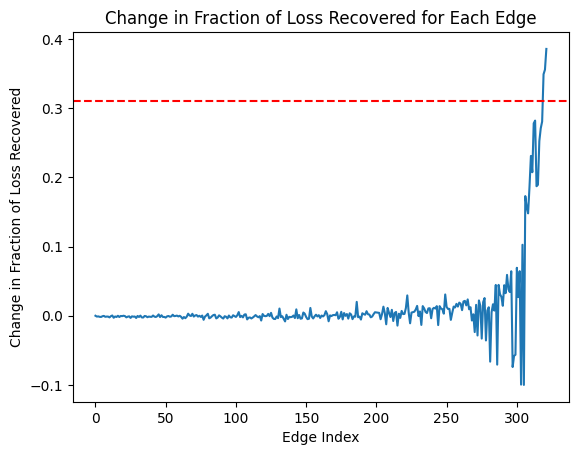

In [24]:
# plot change in loss recovered 
frac_loss_recovered_train = faith_metric_results_train[n_edges_min_equiv_train]['frac_mean_diff_recovered']
# sort edges by prune scores 
edge_prune_scores_train = {
    edge: prune_scores[edge.dest.module_name][edge.patch_idx].cpu().item()
    for edge in edges_train
}
sorted_edge_prune_scores_train = sorted(edge_prune_scores_train.items(), key=lambda x: abs(x[1]), reverse=True)
frac_loss_recovered_sorted = [edge_faith_metric_results_train[edge]['frac_mean_diff_recovered'] for edge, _ in sorted_edge_prune_scores_train]

fig, ax = plt.subplots()
ax.plot([frac_loss_recovered_train - x for x in reversed(frac_loss_recovered_sorted)])
# horizontal line at 1/circuit_size
ax.axhline((1/ len(edges_train)) * 100, color='r', linestyle='--')

ax.set_xlabel("Edge Index")
ax.set_ylabel("Change in Fraction of Loss Recovered")
ax.set_title("Change in Fraction of Loss Recovered for Each Edge")

### Minimality Test

In [55]:
# build full grap to sample paths
from auto_circuit_tests.edge_graph import visualize_graph
graph = SeqGraph(task.model.edges, token=task.token_circuit, attn_only=task.model.cfg.attn_only)

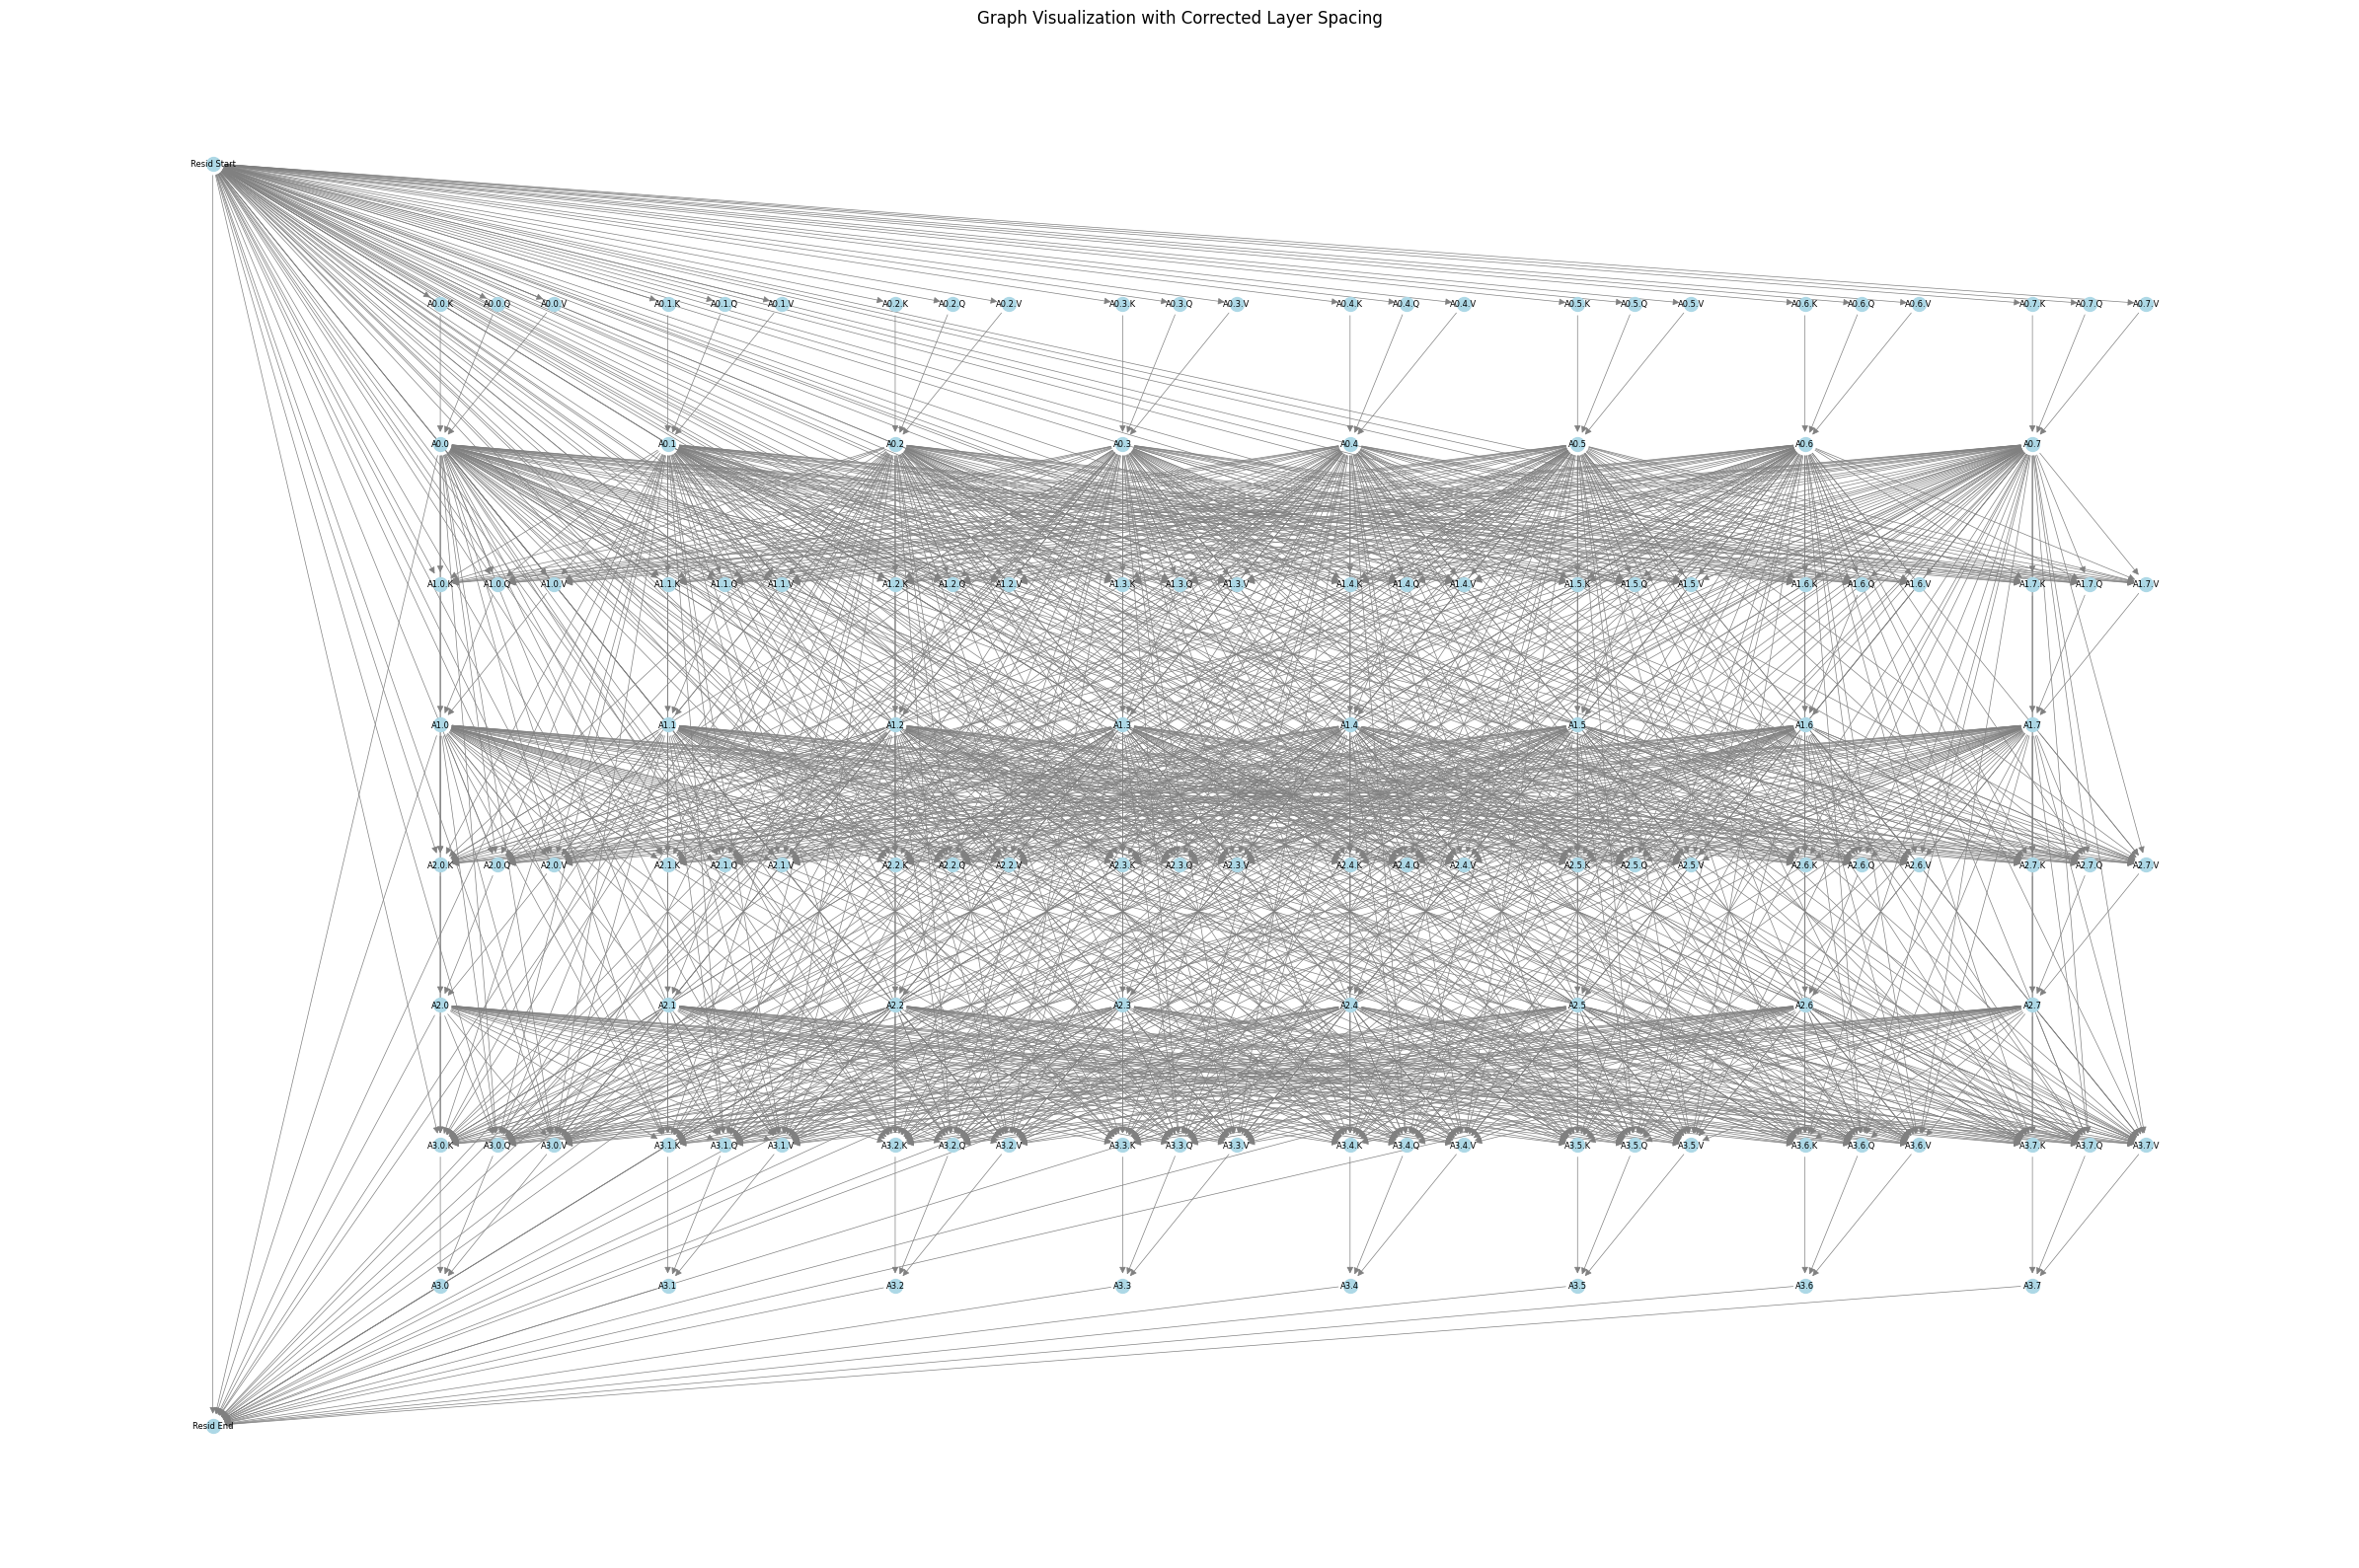

In [56]:
# plot full graph
visualize_graph(graph, sort_by_head=False, max_layer=None)

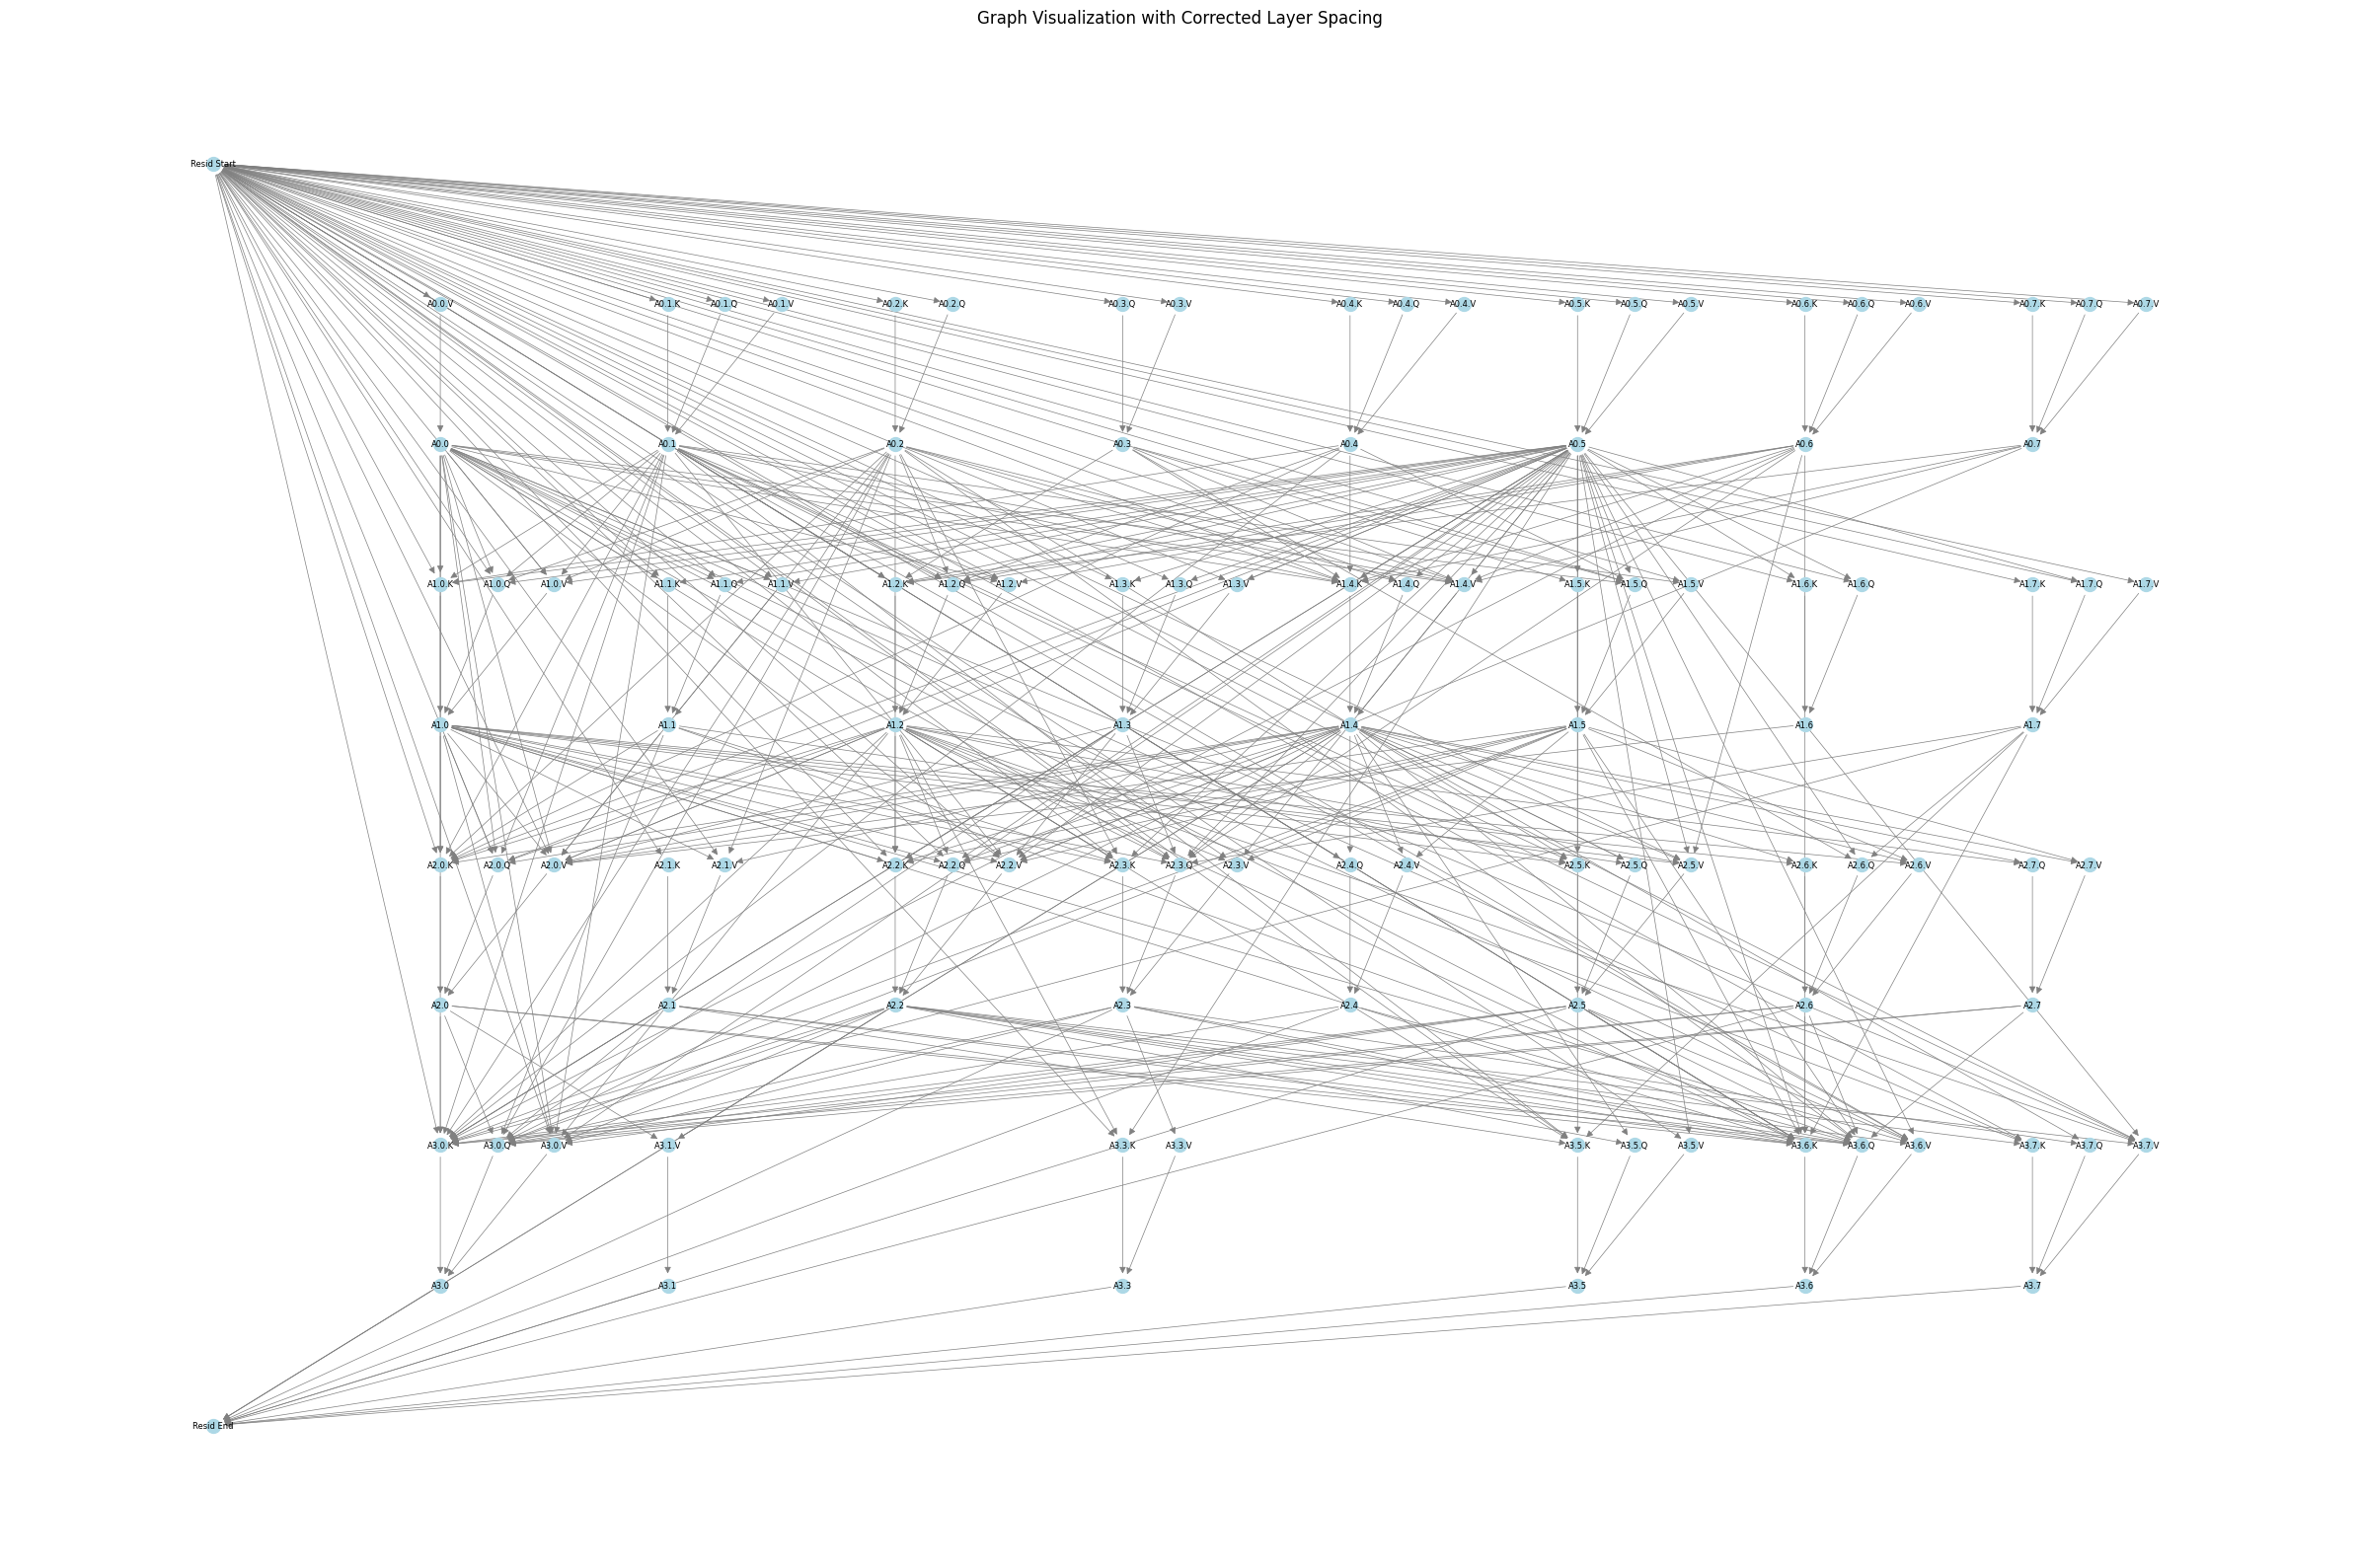

In [57]:
# plot circuit graph
circ_graph = SeqGraph(edges_train, token=task.token_circuit, attn_only=task.model.cfg.attn_only)
visualize_graph(circ_graph, sort_by_head=False, max_layer=None)

In [58]:
# sample paths from complement for each data instance
n_paths = task.batch_size * task.batch_count
complement_edges_train = set(task.model.edges) - set(edges_train)
sampled_paths_train = sample_paths(
    seq_graph=graph, 
    n_paths=n_paths, 
    complement_edges=complement_edges_train,
)
edges_train_set = set(edges_train)
novel_edge_paths_train = [[edge for edge in path if edge not in edges_train_set] for path in sampled_paths_train]

          | 129/? [00:00<00:00, 81485.73it/s]
██████████| 256/256 [00:00<00:00, 9204.66it/s]


In [62]:
novel_edge_paths_train[1], sampled_paths_train[1]

([A1.6->A2.6.Q, A2.6->A3.3.Q],
 [Resid Start->A1.6.Q, A1.6->A2.6.Q, A2.6->A3.3.Q, A3.3->Resid End])

Added edges: [A1.6->A2.6.Q, A2.6->A3.3.Q]
Redundant edges: {A3.3->Resid End, Resid Start->A1.6.Q}


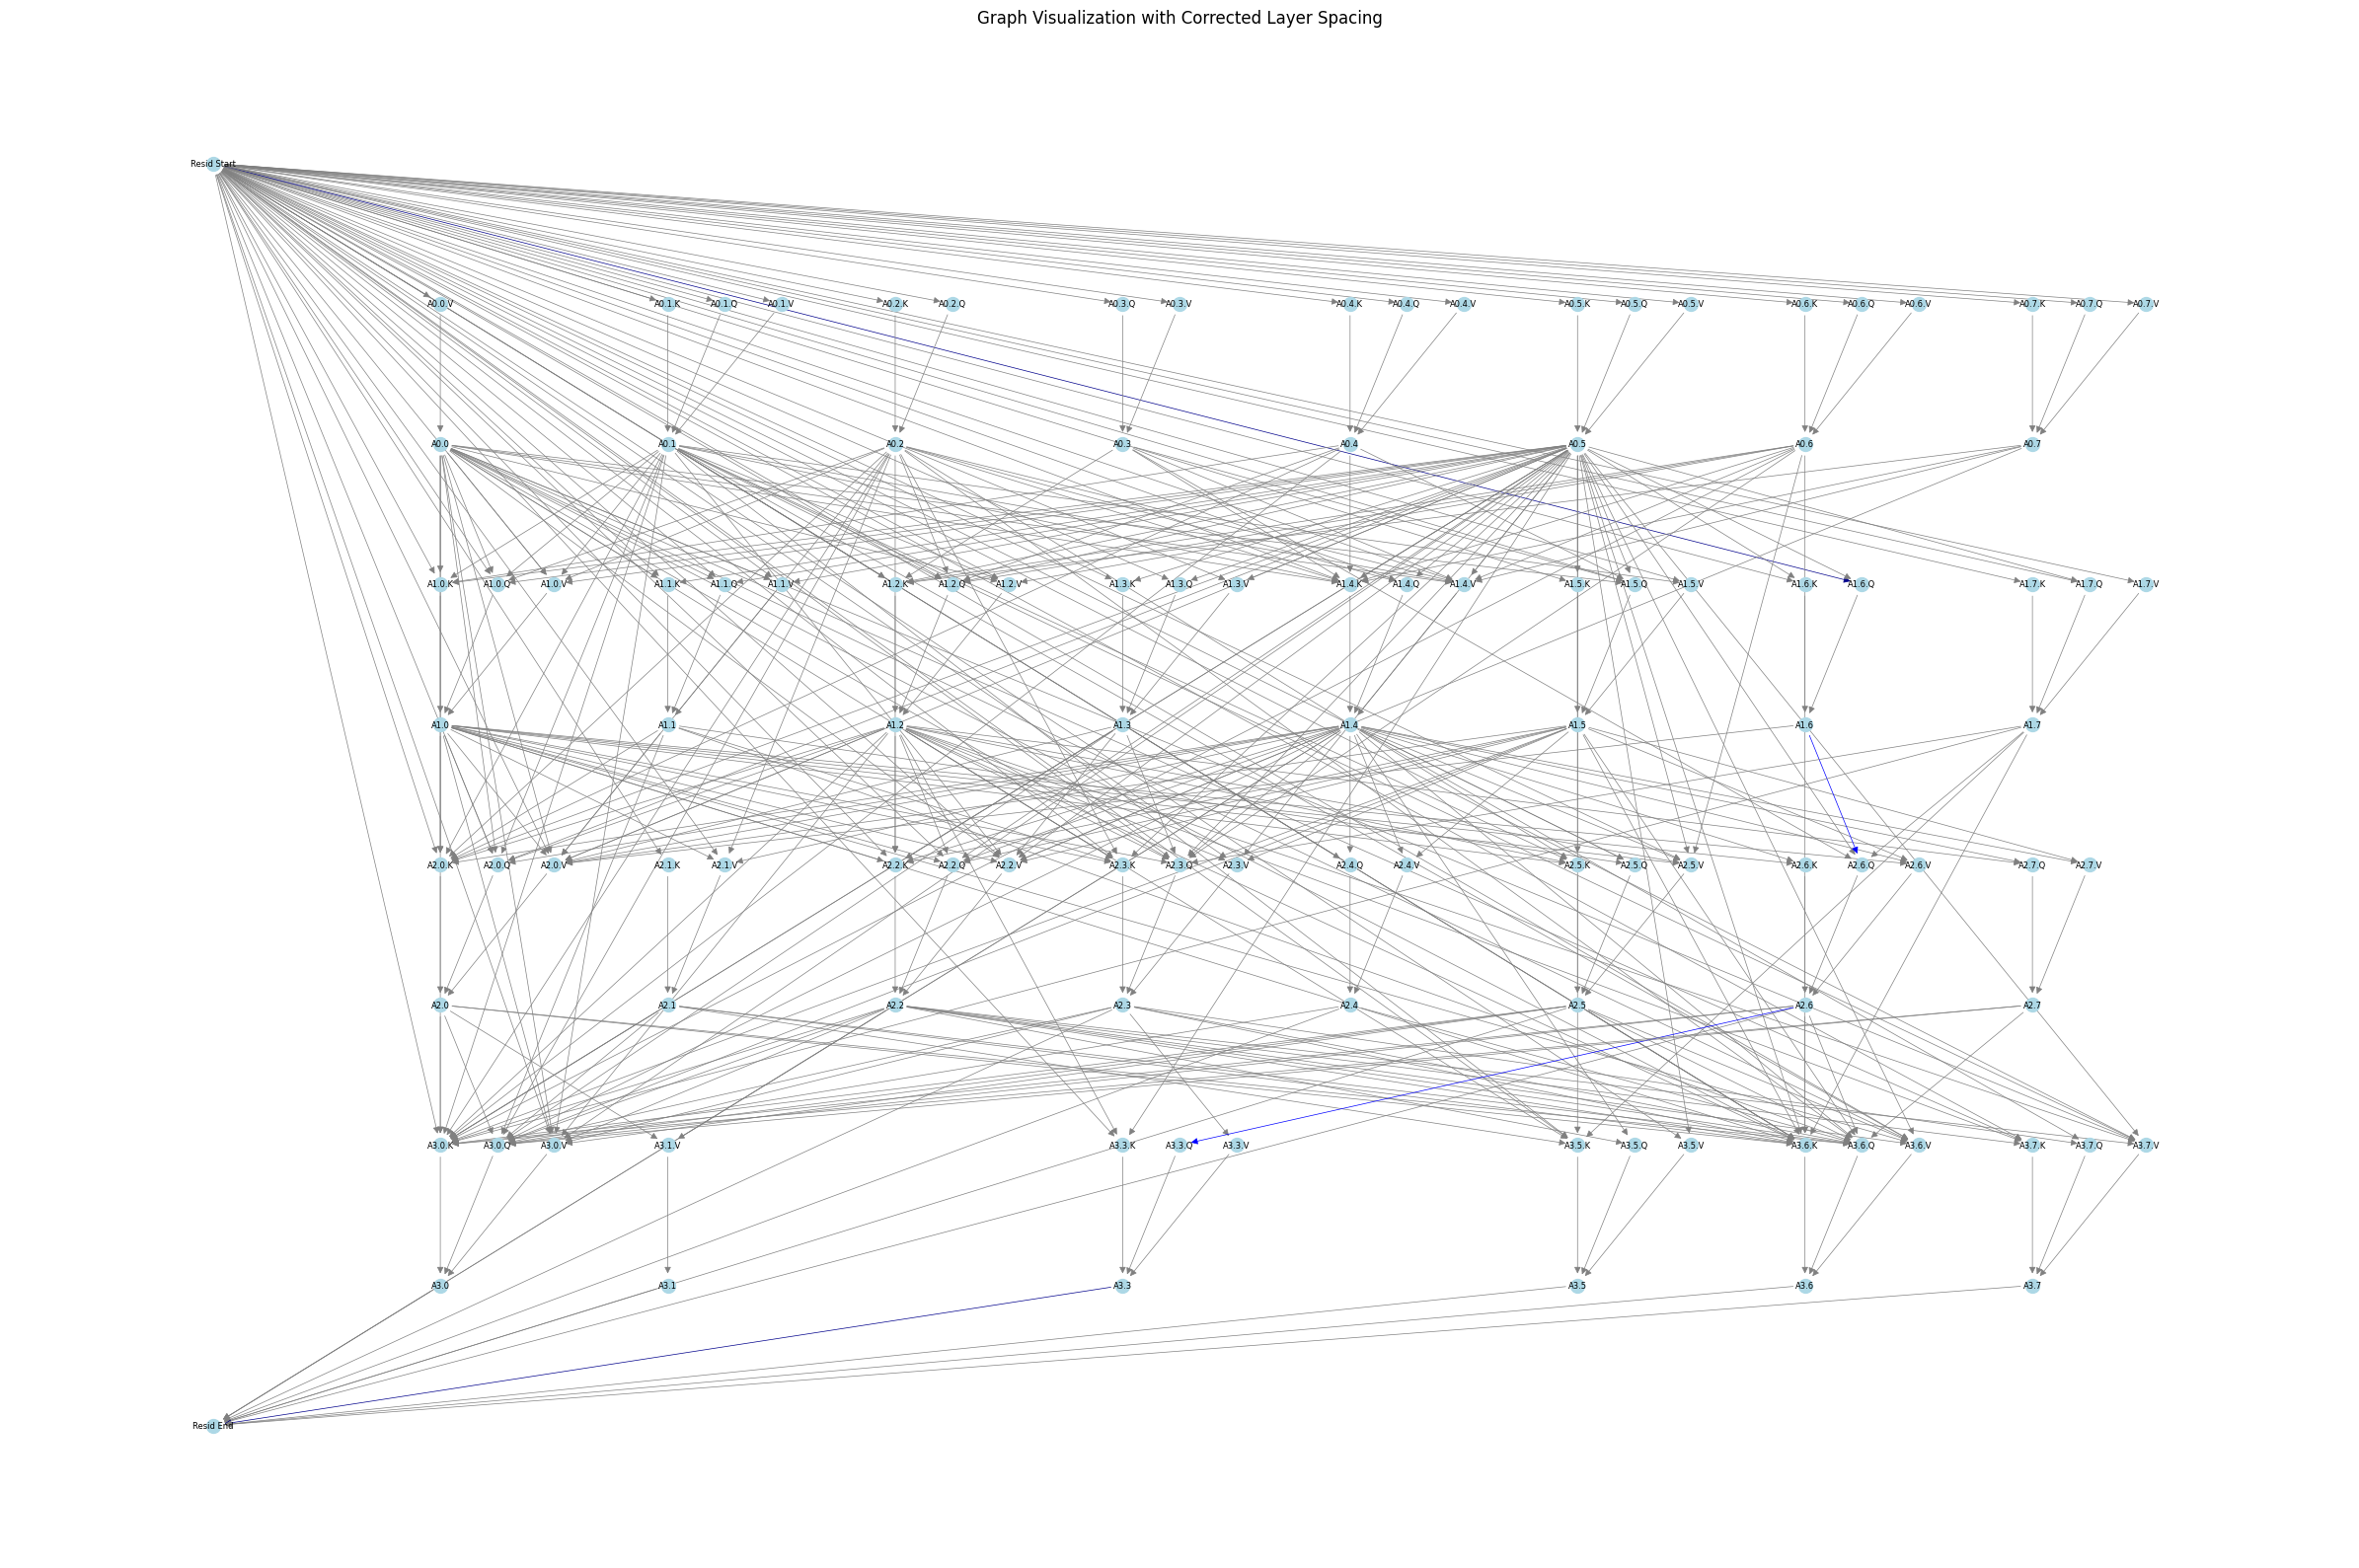

In [67]:
# plot circuit with added path
sampled_path = sampled_paths_train[1]
novel_edges = novel_edge_paths_train[1]
redundant_edges = set(sampled_path).intersection(set(edges_train))
print(f"Added edges: {novel_edges}")
print(f"Redundant edges: {redundant_edges}")
ex_inflated_graph = SeqGraph(edges_train + list(novel_edges), token=task.token_circuit, attn_only=task.model.cfg.attn_only)
edge_colors = {}
[edge_colors.update({edge: 'blue'}) for edge in novel_edges]
[edge_colors.update({edge: 'darkblue'}) for edge in redundant_edges]
visualize_graph(ex_inflated_graph, sort_by_head=False, max_layer=None, edge_colors=edge_colors)


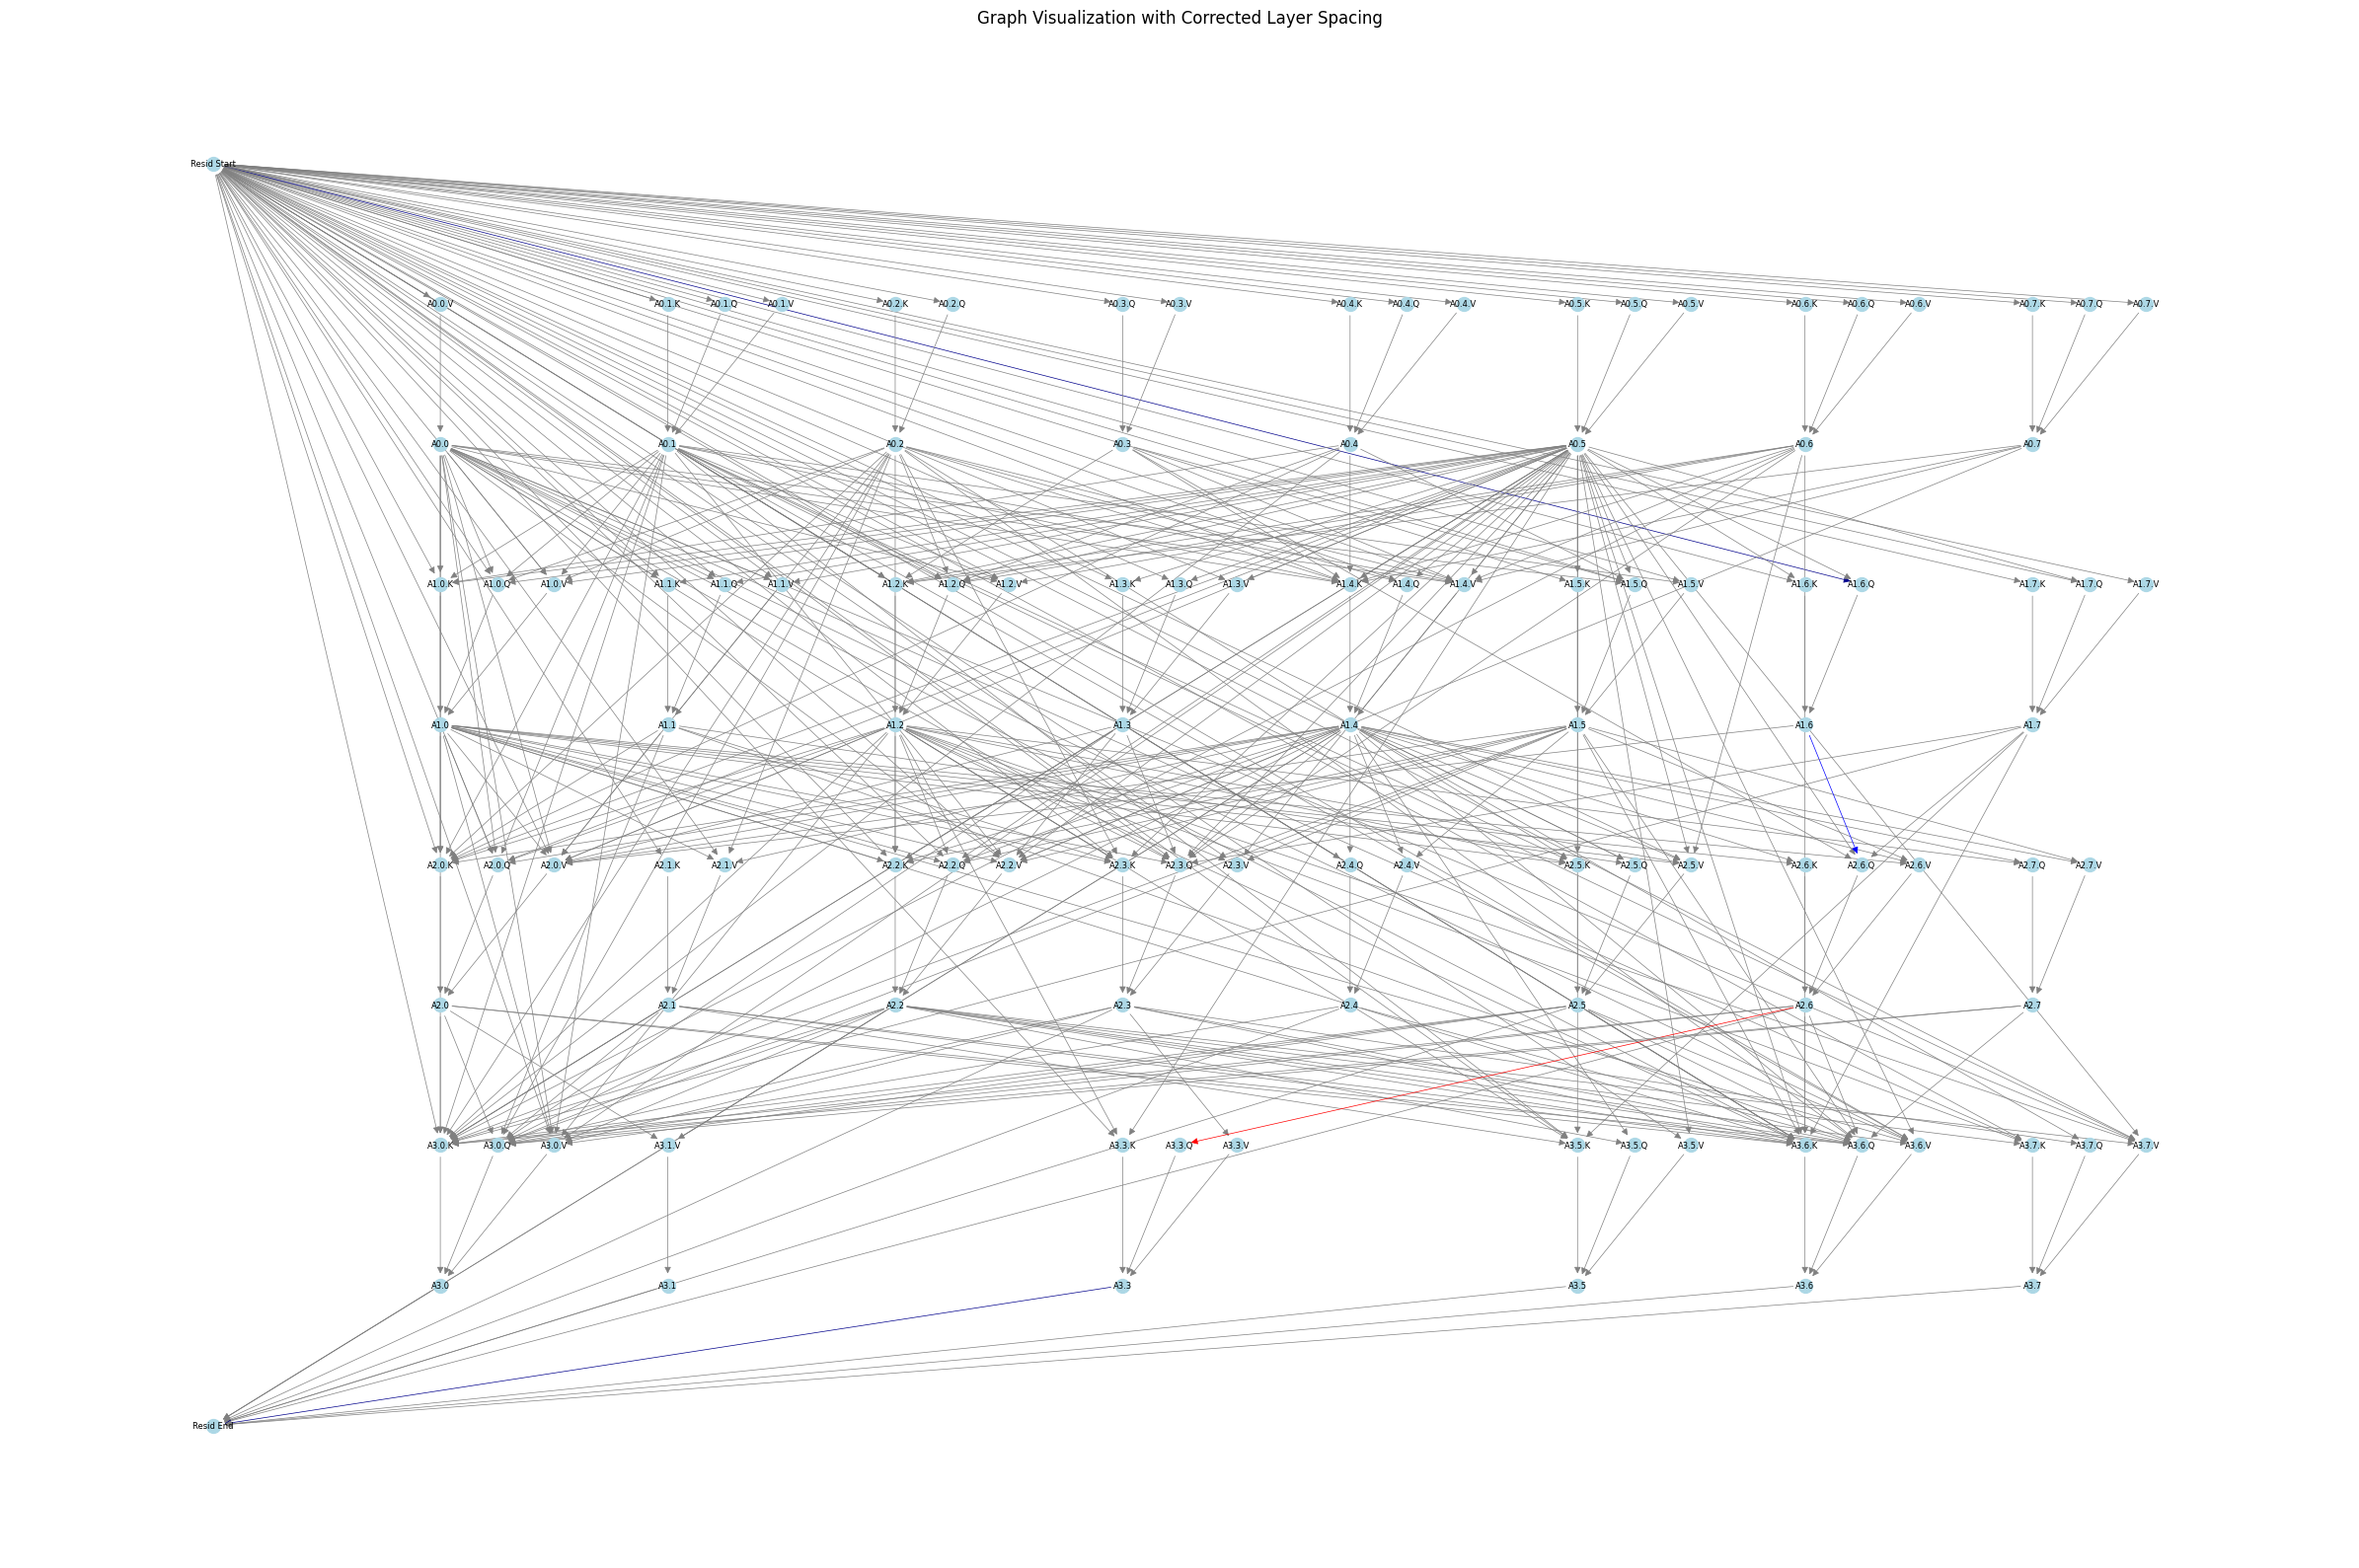

In [68]:
# sample paths to remove 
ablated_paths, removed_edges = [], []
for path in novel_edge_paths_train:
    edge_idx_to_remove = random.choice(range(len(path)))
    ablated_path = remove_el(path, edge_idx_to_remove)
    ablated_paths.append(ablated_path)
    removed_edges.append(path[edge_idx_to_remove])
removed_edge = removed_edges[1]
edge_colors[removed_edge] = 'red'
visualize_graph(ex_inflated_graph, sort_by_head=False, max_layer=None, edge_colors=edge_colors)

In [72]:
import torch as t
def score_diffs(
    dataloader: PromptDataLoader,
    outs_1: BatchOutputs, 
    outs_2: BatchOutputs,
    grad_func: GradFunc,
    answer_func: AnswerFunc,
    device: str = t.device('cuda')
) -> list[t.Tensor]:
    diffs = []
    score_func = get_score_func(grad_func, answer_func)
    for batch in dataloader:
        batch: PromptPairBatch
        score_1 = score_func(outs_1[batch.key].to(device), batch)
        score_2 = score_func(outs_2[batch.key].to(device), batch)
        diffs.append(t.abs(score_1 - score_2).detach().cpu())
    return diffs

In [77]:
# from auto_circuit_tests.hypo_tests.minimality_test import score_diffs
circuit_out_inflated_train, circuit_out_ablated_train = run_circuits_inflated_ablated(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    threshold=train_threshold,
    ablation_type=conf.ablation_type,
    edges=edges_train,
    graph=graph,
    paths=sampled_paths_train,
    ablated_paths=ablated_paths,
    token=task.token_circuit,
)
inflated_ablated_mean_score_diff = torch.cat(score_diffs(
    dataloader=task.train_loader, 
    outs_1=circuit_out_inflated_train, 
    outs_2=circuit_out_ablated_train,
    grad_func=conf.grad_func,
    answer_func=conf.answer_func,
    device=task.device,
)).mean().item()

Pruning Batch 0          | 0/2 [00:00<?, ?it/s]

Pruning Batch 1██████████| 2/2 [00:00<00:00, 14.36it/s]
Pruning Batch 1██████████| 2/2 [00:00<00:00, 14.57it/s]


In [80]:
task

Task(key='Docstring Component Circuit', name='Docstring', batch_size=128, batch_count=2, token_circuit=False, _model_def='attn-only-4l', _dataset_name='docstring_prompts', factorized=True, separate_qkv=True, _true_edge_func=<function docstring_true_edges at 0x7fd55ed8bb50>, slice_output='last_seq', autoencoder_input=None, autoencoder_max_latents=None, autoencoder_pythia_size=None, autoencoder_prune_with_corrupt=None, dtype=torch.float32, __init_complete__=True)

In [78]:
inflated_ablated_mean_score_diff

0.029158703982830048

In [ ]:
min_results_train = {}
for edge in tqdm(edges_train):
    min_results_train[edge] = minimality_test_edge(
        model=task.model,
        dataloader=task.train_loader,
        edge_outs=edge_outs_train[edge],
        circuit_outs=circuit_outs_train[n_edges_min_equiv_train],
        circuit_outs_inflated=circuit_out_inflated_train,
        circuit_outs_ablated=circuit_out_ablated_train,
        grad_func=conf.grad_func,
        answer_func=conf.answer_func,
        null_minimal=False,
        alpha=conf.alpha,# no bonferonni correction b/c we're trying to show minimality
        q_star=conf.q_star,
        device=task.device,
    )

In [ ]:
# plot change in loss recovered 
frac_loss_recovered_train = faith_metric_results_train[n_edges_min_equiv_train]['frac_mean_diff_recovered']
# sort edges by prune scores 
edge_prune_scores_train = {
    edge: prune_scores[edge.dest.module_name][edge.patch_idx].cpu().item()
    for edge in edges_train
}
sorted_edge_prune_scores_train = sorted(edge_prune_scores_train.items(), key=lambda x: abs(x[1]), reverse=True)
frac_loss_recovered_sorted = [edge_faith_metric_results_train[edge]['frac_mean_diff_recovered'] for edge, _ in sorted_edge_prune_scores_train]
null_rejected_sorted = [min_results_train[edge].reject_null for edge, _ in sorted_edge_prune_scores_train]

# plot diff in loss recovered and minimality test results
fig, ax = plt.subplots()
colors = ['green' if rejected else 'red' for rejected in null_rejected_sorted]
bars = ax.bar(range(len(frac_loss_recovered_sorted)), [frac_loss_recovered_train - x for x in frac_loss_recovered_sorted], color=colors)

# plot fraction of edges that are null rejected up to each edge 
cum_num_null_rejected = np.cumsum(null_rejected_sorted)
frac_null_rejected = cum_num_null_rejected / np.arange(1, len(null_rejected_sorted) + 1)
ax2 = ax.twinx()
ax2.plot(frac_null_rejected, color='lightgreen')
ax2.set_ylabel("Fraction of Minimal Edges")

ax.set_xlabel("Edge Order (desc by Prune Scores)")
ax.set_ylabel("Change in Fraction of Loss Recovered")
ax.set_title("Change in Fraction of Loss Recovered for Each Edge")

fig.savefig(edge_dir / "frac_loss_recovered_and_minimality_test_results_train.png")

### Minimality Test on "Ground Truth" Circuit

In [ ]:
true_edges_min_test_results, null_rejected = minimality_test(
    model=task.model, 
    dataloader=task.test_loader,
    edges=task.true_edges,
    prune_scores=task.model.circuit_prune_scores(task.true_edges),
    threshold=conf.prune_score_thresh,
    grad_func=conf.grad_func,
    answer_func=conf.answer_func,
    ablation_type=conf.ablation_type,
    token=task.token_circuit,
    null_minimal=True, 
    bonferonni=True, 
    device=task.device,
)

# Independence Test and Complement %Loss Recovered

## % Loss Recovered of Complement Model

In [ ]:
# get complement outs
complement_outs_train = run_circuits(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.EDGE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=True, # ablated edges are corrupt 
)

complement_outs_test: CircuitOutputs = run_circuits(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.EDGE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=True, # ablated edges are corrupt
)

In [ ]:
# get faithfulness metrics of complement
faith_metric_results_c_train, faith_metrics_c_train = compute_faith_metrics(
    task.train_loader,
    model_out_train, 
    ablated_out_train,
    complement_outs_train,
    conf.grad_func,
    conf.answer_func,
)


faith_metric_results_c_test, faith_metrics_c_test = compute_faith_metrics(
    task.test_loader,
    model_out_test,
    ablated_out_test,
    complement_outs_test,
    conf.grad_func,
    conf.answer_func,
)


save_json(faith_metric_results_c_train, ps_dir, "faith_metric_results_c_train")
save_json(faith_metrics_c_train, ps_dir, "faith_metrics_c_train")
save_json(faith_metric_results_c_test, ps_dir, "faith_metric_results_c_test")
save_json(faith_metrics_c_test, ps_dir, "faith_metrics_c_test")

In [ ]:
[(k, v['frac_mean_diff_recovered']) for k, v in faith_metric_results_c_train.items()]

## Independence HCIC (Frequentist) Test


Test for completeness - if the circuit contains all the components required to perform the task, then the output of the complement should be independent of the original model

$H_0$: Score of complement indepedendent of score of model

Hilbert Schmdit Indepednence Criterion - non-parametric measure of independence 

- Background: (see https://jejjohnson.github.io/research_journal/appendix/similarity/hsic/)

Intuition: the trace sums along the interaction terms on each data point, which 
we expect to be larger then other interaction terms across samples if X, and Y are 
correlated, fewer of the perumations should be greater, our p-value will be smaller, 
and thus we're more likely to reject the null


Note: the hypothesis paper defines HCIC as  K_{x,y}K_{x,y}, but can also define it as 
{K_x}{K_y}, b/c that that equality holds in general for Cross Covariance and Auto 
Covariance 

The paper uses $\rho$ = median(||score(complement) - score(model)||), based on this 
paper https://arxiv.org/pdf/1707.07269

I'm not sure if we can do an interval test, because it seems like we need to assume 
a kind of uniform null - I basically don't understand the test enough

I want to say something like independent only if "p value" between 0.5 +- epsilon 



In [23]:
from auto_circuit_tests.hypo_tests.indep_test import independence_tests

In [50]:
from typing import Callable, Dict, Tuple, Union, Optional, Any, Literal, NamedTuple

import torch 
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import KernelCenterer
from scipy.spatial.distance import cdist

from auto_circuit.data import PromptDataLoader, PromptPairBatch
from auto_circuit.prune import run_circuits
from auto_circuit.types import PruneScores, BatchOutputs, CircuitOutputs, PatchType, AblationType
from auto_circuit.utils.patchable_model import PatchableModel
from auto_circuit.utils.custom_tqdm import tqdm

from auto_circuit_tests.score_funcs import GradFunc, AnswerFunc, get_score_func
# from auto_circuit_tests.hypo_tests.equiv_test import equiv_test



def hsic(X: np.ndarray, Y: np.ndarray, gamma: float) -> float:
    """(Hilbert-Schmidt Independence Criterion"""
    K_X = rbf_kernel(X, gamma=gamma)
    K_Y = rbf_kernel(Y, gamma=gamma)
    centerer = KernelCenterer()
    K_X_c = centerer.fit_transform(K_X)
    K_Y_c = centerer.fit_transform(K_Y)
    return np.trace(K_X_c @ K_Y_c)


def indep_test(X: np.ndarray, Y: np.ndarray, B: int, alpha: float) -> Tuple[bool, int, float]:
    rho = np.median(cdist(X, Y, metric='euclidean')) #torch.cdist(model_scores, comp_circuit_scores, p=2).median().item()
    print(rho)
    gamma = 1/rho
    t_obs = hsic(X, Y, gamma=gamma)
    t = 0
    for b in range(B):
        # permutate X
        perm_X = np.random.permutation(X)
        # compute the new HSIC value 
        t_i = hsic(perm_X, Y, gamma=gamma)
        # increment t with 1 if new value greater
        t += t_obs < t_i
    p_value = t / B
    return p_value < alpha, t, p_value


class IndepResults(NamedTuple):
    num_t_gt_t_obs: int
    B: int
    p_value: float
    reject_null: bool
    complement_model_scores: torch.Tensor
    model_scores: torch.Tensor


def independence_tests(
    model: PatchableModel,
    dataloader: PromptDataLoader,
    prune_scores: PruneScores,
    grad_function: GradFunc,
    answer_function: AnswerFunc,
    ablation_type: AblationType,
    edge_counts: Optional[list[int]] = None,
    thresholds: Optional[list[float]] = None,
    model_out: Optional[BatchOutputs] = None,
    complement_circuit_outs: Optional[CircuitOutputs] = None,
    alpha: float = 0.05,
    B: int = 1000,
) -> Dict[int, IndepResults]:

    # compute complement outs 
    if complement_circuit_outs is None:
        complement_circuit_outs = run_circuits(
        model=model, 
        dataloader=dataloader,
        prune_scores=prune_scores,
        test_edge_counts=edge_counts,
        thresholds=thresholds,
        patch_type=PatchType.EDGE_PATCH, 
        ablation_type=ablation_type,
        reverse_clean_corrupt=True, 
    )
    # compute model out 
    if model_out is None:
        model_out: BatchOutputs = {}
        for batch in dataloader:
            model_out[batch.key] = model(batch.clean)[model.out_slice]

    # compute scores
    score_func = get_score_func(grad_function, answer_function)
    test_results = {}
    for edge_count, comp_circuit_out in tqdm(complement_circuit_outs.items()):
        comp_circuit_scores = []
        model_scores = []
        for batch in dataloader:
            model_scores.append(score_func(model_out[batch.key], batch).cpu()) 
            comp_circuit_scores.append(score_func(comp_circuit_out[batch.key], batch).cpu())
        model_scores = torch.cat(model_scores)[:, None]
        comp_circuit_scores = torch.cat(comp_circuit_scores)[:, None]

        # run independencde test 
        reject_null, t, p_value = indep_test(
            model_scores.numpy(), comp_circuit_scores.numpy(), B=B, alpha=alpha
        )
       
        # store results
        test_results[edge_count] = IndepResults(
            num_t_gt_t_obs=t, B=B, p_value=p_value, reject_null=reject_null, 
            complement_model_scores=comp_circuit_scores, model_scores=model_scores
        )
    return test_results



In [ ]:
indep_results_train = independence_tests(
    model=task.model, 
    dataloader=task.train_loader, 
    prune_scores=prune_scores, 
    grad_function=conf.grad_func,
    answer_function=conf.answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_train,
    complement_circuit_outs=complement_outs_train,
    alpha=conf.alpha,
    B=1000
)

In [ ]:
[(k, (v.p_value, faith_metric_results_c_train[k]['frac_mean_diff_recovered'])) for k, v in indep_results_train.items()]

In [ ]:
indep_results_test = independence_tests(
    model=task.model, 
    dataloader=task.test_loader, 
    prune_scores=prune_scores, 
    grad_function=conf.grad_func,
    answer_function=conf.answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_test,
    complement_circuit_outs=complement_outs_test,
    alpha=conf.alpha,
    B=1000
)

In [ ]:
[(k, (v.p_value, faith_metric_results_c_test[k]['frac_mean_diff_recovered'])) for k, v in indep_results_test.items()]

In [ ]:
indep_true_edge_result_train = next(iter(independence_tests(
    task.model, 
    task.train_loader, 
    task.model.circuit_prune_scores(task.true_edges), 
    ablation_type=conf.ablation_type,
    grad_function=conf.grad_func,
    answer_function=conf.answer_func,
    thresholds=[0.5], 
    model_out=model_out_train,
    alpha=conf.alpha,
    B=1000
).values()))

In [ ]:
indep_true_edge_result_train.reject_null, indep_true_edge_result_train.p_value

In [ ]:
indep_true_edge_result = next(iter(independence_tests(
    task.model, 
    task.test_loader, 
    task.model.circuit_prune_scores(task.true_edges), 
    ablation_type=conf.ablation_type,
    grad_function=conf.grad_func,
    answer_function=conf.answer_func,
    thresholds=[0.5], 
    model_out=model_out_test,
    alpha=conf.alpha,
    B=1000
).values()))
save_json(result_to_json(indep_true_edge_result), out_answer_dir, f"indep_true_edge_result")

In [ ]:
indep_true_edge_result.reject_null, indep_true_edge_result.p_value # hmm... should should be true... should check implmeentation, try on component ciruits